In [ ]:
!pip install nltk

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize
import nltk
import os

In [ ]:
# document = """About the Program
# What is the course fee for  Data Science Mentorship Program (DSMP 2023)
# The course follows a monthly subscription model where you have to make monthly payments of Rs 799/month.
# What is the total duration of the course?
# The total duration of the course is 7 months. So the total course fee becomes 799*7 = Rs 5600(approx.)
# What is the syllabus of the mentorship program?
# We will be covering the following modules:
# Python Fundamentals
# Python libraries for Data Science
# Data Analysis
# SQL for Data Science
# Maths for Machine Learning
# ML Algorithms
# Practical ML
# MLOPs
# Case studies
# You can check the detailed syllabus here - https://learnwith.campusx.in/courses/CampusX-Data-Science-Mentorship-Program-637339afe4b0615a1bbed390
# Will Deep Learning and NLP be a part of this program?
# No, NLP and Deep Learning both are not a part of this program’s curriculum.
# What if I miss a live session? Will I get a recording of the session?
# Yes all our sessions are recorded, so even if you miss a session you can go back and watch the recording.
# Where can I find the class schedule?
# Checkout this google sheet to see month by month time table of the course - https://docs.google.com/spreadsheets/d/16OoTax_A6ORAeCg4emgexhqqPv3noQPYKU7RJ6ArOzk/edit?usp=sharing.
# What is the time duration of all the live sessions?
# Roughly, all the sessions last 2 hours.
# What is the language spoken by the instructor during the sessions?
# Hinglish
# How will I be informed about the upcoming class?
# You will get a mail from our side before every paid session once you become a paid user.
# Can I do this course if I am from a non-tech background?
# Yes, absolutely.
# I am late, can I join the program in the middle?
# Absolutely, you can join the program anytime.
# If I join/pay in the middle, will I be able to see all the past lectures?
# Yes, once you make the payment you will be able to see all the past content in your dashboard.
# Where do I have to submit the task?
# You don’t have to submit the task. We will provide you with the solutions, you have to self evaluate the task yourself.
# Will we do case studies in the program?
# Yes.
# Where can we contact you?
# You can mail us at nitish.campusx@gmail.com
# Payment/Registration related questions
# Where do we have to make our payments? Your YouTube channel or website?
# You have to make all your monthly payments on our website. Here is the link for our website - https://learnwith.campusx.in/
# Can we pay the entire amount of Rs 5600 all at once?
# Unfortunately no, the program follows a monthly subscription model.
# What is the validity of monthly subscription? Suppose if I pay on 15th Jan, then do I have to pay again on 1st Feb or 15th Feb
# 15th Feb. The validity period is 30 days from the day you make the payment. So essentially you can join anytime you don’t have to wait for a month to end.
# What if I don’t like the course after making the payment. What is the refund policy?
# You get a 7 days refund period from the day you have made the payment.
# I am living outside India and I am not able to make the payment on the website, what should I do?
# You have to contact us by sending a mail at nitish.campusx@gmail.com
# Post registration queries
# Till when can I view the paid videos on the website?
# This one is tricky, so read carefully. You can watch the videos till your subscription is valid. Suppose you have purchased subscription on 21st Jan, you will be able to watch all the past paid sessions in the period of 21st Jan to 20th Feb. But after 21st Feb you will have to purchase the subscription again.
# But once the course is over and you have paid us Rs 5600(or 7 installments of Rs 799) you will be able to watch the paid sessions till Aug 2024.
# Why lifetime validity is not provided?
# Because of the low course fee.
# Where can I reach out in case of a doubt after the session?
# You will have to fill a google form provided in your dashboard and our team will contact you for a 1 on 1 doubt clearance session
# If I join the program late, can I still ask past week doubts?
# Yes, just select past week doubt in the doubt clearance google form.
# I am living outside India and I am not able to make the payment on the website, what should I do?
# You have to contact us by sending a mail at nitish.campusx@gmai.com
# Certificate and Placement Assistance related queries
# What is the criteria to get the certificate?
# There are 2 criterias:
# You have to pay the entire fee of Rs 5600
# You have to attempt all the course assessments.
# I am joining late. How can I pay payment of the earlier months?
# You will get a link to pay fee of earlier months in your dashboard once you pay for the current month.
# I have read that Placement assistance is a part of this program. What comes under Placement assistance?
# This is to clarify that Placement assistance does not mean Placement guarantee. So we dont guarantee you any jobs or for that matter even interview calls. So if you are planning to join this course just for placements, I am afraid you will be disappointed. Here is what comes under placement assistance
# Portfolio Building sessions
# Soft skill sessions
# Sessions with industry mentors
# Discussion on Job hunting strategies
# """

# instead of hardcoding the text, read from a file
def load_document(path="faq.txt"):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Dataset file {path} not found. Please place it in the project folder.")
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()
    print(f"[INFO] Loaded corpus from {path} ({len(text):,} characters)")
    return text

# usage
document = load_document("kgdata3.txt")


[INFO] Loaded corpus from kgdata3.txt (581,888 characters)


In [ ]:
# Tokenization
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# tokenize
tokens = word_tokenize(document.lower())

In [ ]:
Counter(tokens)

Counter({'\ufeff': 1,
         'project': 90,
         'gutenberg': 33,
         "'s": 6,
         'the': 5799,
         'adventures': 10,
         'of': 2775,
         'sherlock': 102,
         'holmes': 460,
         ',': 7799,
         'by': 374,
         'arthur': 24,
         'conan': 4,
         'doyle': 4,
         'this': 532,
         'ebook': 11,
         'is': 1138,
         'for': 749,
         'use': 43,
         'anyone': 29,
         'anywhere': 4,
         'at': 780,
         'no': 392,
         'cost': 6,
         'and': 3071,
         'with': 878,
         'almost': 20,
         'restrictions': 2,
         'whatsoever': 2,
         '.': 4498,
         'you': 1530,
         'may': 213,
         'copy': 14,
         'it': 1702,
         'give': 64,
         'away': 105,
         'or': 275,
         're-use': 2,
         'under': 48,
         'terms': 24,
         'license': 17,
         'included': 4,
         'online': 4,
         'www.gutenberg.net': 1,
         'titl

In [ ]:
# # build vocab
# vocab = {'<unk>':0}

# for token in Counter(tokens).keys():
#   if token not in vocab:
#     vocab[token] = len(vocab)

# vocab


from collections import Counter

def build_vocab(tokens, min_freq=2):
    vocab = {'<unk>': 0}
    counts = Counter(tokens)
    for word, freq in counts.items():
        if freq >= min_freq:  # ignore rare words
            vocab[word] = len(vocab)
    return vocab

vocab = build_vocab(tokens, min_freq=3)
print("Vocab size:", len(vocab))

# If we set min_freq=2

# Then "hi" and "are" would stay:

# {'<unk>': 0, 'hi': 1, 'are': 2}


{'<unk>': 0,
 '\ufeff': 1,
 'project': 2,
 'gutenberg': 3,
 "'s": 4,
 'the': 5,
 'adventures': 6,
 'of': 7,
 'sherlock': 8,
 'holmes': 9,
 ',': 10,
 'by': 11,
 'arthur': 12,
 'conan': 13,
 'doyle': 14,
 'this': 15,
 'ebook': 16,
 'is': 17,
 'for': 18,
 'use': 19,
 'anyone': 20,
 'anywhere': 21,
 'at': 22,
 'no': 23,
 'cost': 24,
 'and': 25,
 'with': 26,
 'almost': 27,
 'restrictions': 28,
 'whatsoever': 29,
 '.': 30,
 'you': 31,
 'may': 32,
 'copy': 33,
 'it': 34,
 'give': 35,
 'away': 36,
 'or': 37,
 're-use': 38,
 'under': 39,
 'terms': 40,
 'license': 41,
 'included': 42,
 'online': 43,
 'www.gutenberg.net': 44,
 'title': 45,
 ':': 46,
 'author': 47,
 'release': 48,
 'date': 49,
 'november': 50,
 '29': 51,
 '2002': 52,
 '[': 53,
 '#': 54,
 '1661': 55,
 ']': 56,
 'last': 57,
 'updated': 58,
 '20': 59,
 '2019': 60,
 'language': 61,
 'english': 62,
 'character': 63,
 'set': 64,
 'encoding': 65,
 'utf-8': 66,
 '*': 67,
 'start': 68,
 'produced': 69,
 'an': 70,
 'anonymous': 71,
 'volunt

In [ ]:
len(vocab)

9399

In [ ]:
input_sentences = document.split('\n')

In [ ]:
def text_to_indices(sentence, vocab):

  numerical_sentence = []

  for token in sentence:
    if token in vocab:
      numerical_sentence.append(vocab[token])
    else:
      numerical_sentence.append(vocab['<unk>'])

  return numerical_sentence


In [ ]:
input_numerical_sentences = []

for sentence in input_sentences:
  input_numerical_sentences.append(text_to_indices(word_tokenize(sentence.lower()), vocab))


In [ ]:
len(input_numerical_sentences)

12311

In [ ]:

training_sequence = []
for sentence in input_numerical_sentences:

  for i in range(1, len(sentence)):
    training_sequence.append(sentence[:i+1])

In [ ]:
len(training_sequence)

120233

In [ ]:
training_sequence[:5]
#0, 1, 2, 3, 4

[[2, 3], [2, 3, 4], [2, 3, 4, 5], [2, 3, 4, 5, 6], [2, 3, 4, 5, 6, 7]]

In [ ]:
len_list = []

for sequence in training_sequence:
  len_list.append(len(sequence))

max(len_list)

29

In [ ]:
training_sequence[0]

[2, 3]

In [ ]:
padded_training_sequence = []
for sequence in training_sequence:

  padded_training_sequence.append([0]*(max(len_list) - len(sequence)) + sequence)

In [ ]:
len(padded_training_sequence[10])

29

In [ ]:
padded_training_sequence = torch.tensor(padded_training_sequence, dtype=torch.long)

In [ ]:
padded_training_sequence

tensor([[   0,    0,    0,  ...,    0,    2,    3],
        [   0,    0,    0,  ...,    2,    3,    4],
        [   0,    0,    0,  ...,    3,    4,    5],
        ...,
        [   0,    0,    0,  ...,  588, 1172,  417],
        [   0,    0,    0,  ..., 1172,  417, 9112],
        [   0,    0,    0,  ...,  417, 9112,   30]])

In [ ]:
X = padded_training_sequence[:, :-1] #gives you every row, but drops the last column
y = padded_training_sequence[:,-1] #gives you just the last column of each row.

In [ ]:
X

tensor([[   0,    0,    0,  ...,    0,    0,    2],
        [   0,    0,    0,  ...,    0,    2,    3],
        [   0,    0,    0,  ...,    2,    3,    4],
        ...,
        [   0,    0,    0,  ...,  121,  588, 1172],
        [   0,    0,    0,  ...,  588, 1172,  417],
        [   0,    0,    0,  ..., 1172,  417, 9112]])

In [ ]:
y

tensor([   3,    4,    5,  ...,  417, 9112,   30])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X    # features (inputs)
        self.y = y    # labels (targets)

    def __len__(self):
        return self.X.shape[0]   # number of samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]  # return one sample (x, y)


In [ ]:
dataset = CustomDataset(X,y)

In [ ]:
len(dataset)

120233

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

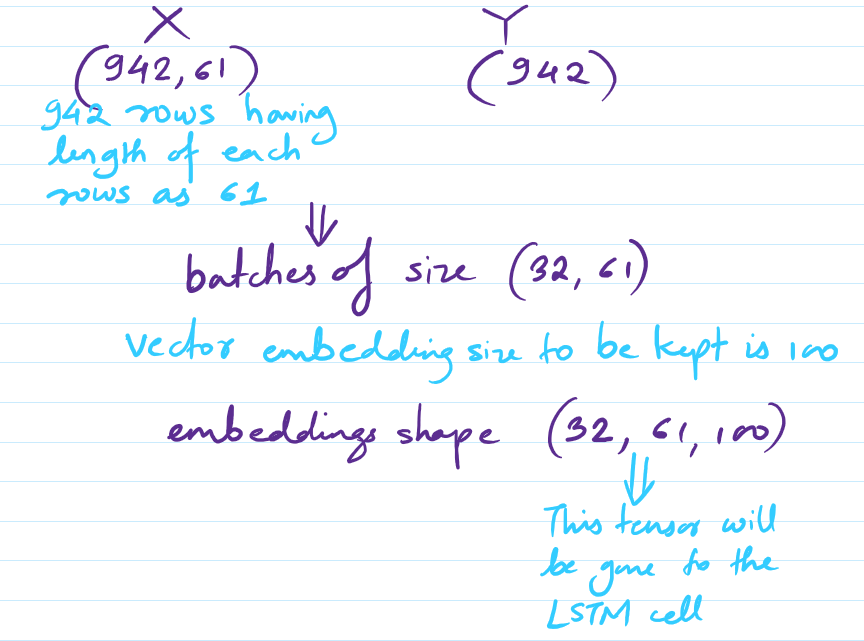

In [ ]:
class LSTMModel(nn.Module):

  def __init__(self, vocab_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, 100)
    self.lstm = nn.LSTM(100, 150, batch_first=True)
    self.fc = nn.Linear(150, vocab_size)

  def forward(self, x):
    embedded = self.embedding(x)
    intermediate_hidden_states, (final_hidden_state, final_cell_state) = self.lstm(embedded)
    output = self.fc(final_hidden_state.squeeze(0))
    return output

The outputs which we will get from LSTM cell for a batch size of 61 is : all the hidden states (61 intermediate states along with the final hidden state) and ct and ht of the last time step

In [ ]:
model = LSTMModel(len(vocab))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model.to(device)

LSTMModel(
  (embedding): Embedding(9399, 100)
  (lstm): LSTM(100, 150, batch_first=True)
  (fc): Linear(in_features=150, out_features=9399, bias=True)
)

In [ ]:
epochs = 20
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# training loop

for epoch in range(epochs):
  total_loss = 0

  for batch_x, batch_y in dataloader:

    batch_x, batch_y = batch_x.to(device), batch_y.to(device)

    optimizer.zero_grad()

    output = model(batch_x)

    loss = criterion(output, batch_y)

    loss.backward()

    optimizer.step()

    total_loss = total_loss + loss.item()

  print(f"Epoch: {epoch + 1}, Loss: {total_loss:.4f}")

Epoch: 1, Loss: 20622.5079
Epoch: 2, Loss: 17558.1233
Epoch: 3, Loss: 15958.9778
Epoch: 4, Loss: 14607.3892
Epoch: 5, Loss: 13428.3485
Epoch: 6, Loss: 12381.4470
Epoch: 7, Loss: 11451.8487
Epoch: 8, Loss: 10610.0165
Epoch: 9, Loss: 9853.9093
Epoch: 10, Loss: 9183.7173
Epoch: 11, Loss: 8572.3431
Epoch: 12, Loss: 8030.3753
Epoch: 13, Loss: 7535.7261
Epoch: 14, Loss: 7103.1829
Epoch: 15, Loss: 6697.5647
Epoch: 16, Loss: 6353.2788
Epoch: 17, Loss: 6030.5467
Epoch: 18, Loss: 5737.6445
Epoch: 19, Loss: 5469.0925
Epoch: 20, Loss: 5233.8378


In [ ]:
# prediction

def prediction(model, vocab, text):

  # tokenize
  tokenized_text = word_tokenize(text.lower())

  # text -> numerical indices
  numerical_text = text_to_indices(tokenized_text, vocab)

  # padding
  padded_text = torch.tensor([0] * (61 - len(numerical_text)) + numerical_text, dtype=torch.long).unsqueeze(0)

  # send to model
  output = model(padded_text)

  # predicted index
  value, index = torch.max(output, dim=1)

  # merge with text
  return text + " " + list(vocab.keys())[index]



In [ ]:
prediction(model, vocab, "The course follows a monthly")

'The course follows a monthly .'

In [ ]:
import time

num_tokens = 40
input_text = "hi how are"

for i in range(num_tokens):
  output_text = prediction(model, vocab, input_text)
  print(output_text)
  input_text = output_text
  time.sleep(0.5)


hi how are they
hi how are they .
hi how are they . they
hi how are they . they had
hi how are they . they had been
hi how are they . they had been a
hi how are they . they had been a previous
hi how are they . they had been a previous them
hi how are they . they had been a previous them ,
hi how are they . they had been a previous them , you
hi how are they . they had been a previous them , you understand
hi how are they . they had been a previous them , you understand in
hi how are they . they had been a previous them , you understand in return
hi how are they . they had been a previous them , you understand in return to
hi how are they . they had been a previous them , you understand in return to the
hi how are they . they had been a previous them , you understand in return to the study
hi how are they . they had been a previous them , you understand in return to the study of
hi how are they . they had been a previous them , you understand in return to the study of the
hi how are th

In [ ]:
dataloader1 = DataLoader(dataset, batch_size=32, shuffle=False)

In [ ]:
# Function to calculate accuracy
def calculate_accuracy(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to compute gradients
        for batch_x, batch_y in dataloader1:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Get model predictions
            outputs = model(batch_x)

            # Get the predicted word indices
            _, predicted = torch.max(outputs, dim=1)

            # Compare with actual labels
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    accuracy = correct / total * 100
    return accuracy

# Compute accuracy
accuracy = calculate_accuracy(model, dataloader, device)
print(f"Model Accuracy: {accuracy:.2f}%")


Model Accuracy: 73.44%


✂️ Gradient Clipping

When training, the LSTM adjusts itself using gradients (the little nudges from backpropagation).

Sometimes these gradients blow up (get huge numbers) → then training explodes and the model fails.

Gradient clipping = “if gradients are too big, cut them down to a safe size.”

Think of it like putting a speed limit so training doesn’t go out of control.

🌀 Perplexity

Perplexity is just a score of how confused the model is when predicting the next word.

Lower perplexity = the model is less “perplexed” → it’s better at guessing.

Example:

If perplexity = 10 → “on average, the model feels like it had to choose between 10 options.”

If perplexity = 2 → “it’s mostly down to 2 likely words — way less confused.”

So in LSTM word prediction, you train until perplexity gets smaller → means it’s learning.

In [ ]:
# lstm_next_word.py
import os
import math
import random
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import Dataset, DataLoader, random_split

import nltk
from nltk.tokenize import word_tokenize

# ---------------------------
# 0) Reproducibility
# ---------------------------
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# ---------------------------
# 1) Data loading
# ---------------------------
def load_document(path="kgdata3.txt"):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Dataset file {path} not found. Put it next to this script.")
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()
    print(f"[INFO] Loaded corpus from {path} ({len(text):,} chars)")
    return text

# ---------------------------
# 2) Tokenize + vocab
# ---------------------------
def build_vocab(tokens, min_freq=2):
    # reserve 0,1 for pad/unk
    vocab = {"<pad>": 0, "<unk>": 1}
    counts = Counter(tokens)
    for w, c in counts.items():
        if c >= min_freq and w not in vocab:
            vocab[w] = len(vocab)
    return vocab

def numericalize(tokens, vocab):
    unk = vocab["<unk>"]
    return [vocab.get(t, unk) for t in tokens]

# ---------------------------
# 3) Dataset: prefixes -> next token
# ---------------------------
class NextWordDataset(Dataset):
    """
    Each example is (prefix_tokens, next_token_id)
    We keep variable-length inputs; padding happens in collate_fn.
    """
    def __init__(self, sentences, vocab, min_len=2):
        self.samples = []
        pad = vocab["<pad>"]  # not used here but kept for clarity
        for sent in sentences:
            toks = [t for t in word_tokenize(sent.lower()) if t.strip()]
            if len(toks) < min_len:
                continue
            ids = numericalize(toks, vocab)
            # prefixes: [ids[:i]] predict ids[i] (i from 1..len(ids)-1)
            for i in range(1, len(ids)):
                prefix = ids[:i]
                target = ids[i]
                self.samples.append((torch.tensor(prefix, dtype=torch.long), target))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

def collate_fn(batch, pad_idx=0):
    """
    batch: list of (prefix_tensor, target_id)
    Returns:
      x_padded: (B, T) long
      lengths:  (B,)  long
      targets:  (B,)  long
    """
    prefixes, targets = zip(*batch)
    lengths = torch.tensor([len(p) for p in prefixes], dtype=torch.long)
    x_padded = pad_sequence(prefixes, batch_first=True, padding_value=pad_idx)
    targets = torch.tensor(targets, dtype=torch.long)
    return x_padded, lengths, targets

# ---------------------------
# 4) Model
# ---------------------------
class LSTMNextWord(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hidden_dim=256, num_layers=2, pad_idx=0, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,          # applies between layers (num_layers>1)
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)

        # Init: orthogonal recurrent, xavier input, positive forget bias
        for name, param in self.lstm.named_parameters():
            if "weight_ih" in name:
                nn.init.xavier_uniform_(param)
            elif "weight_hh" in name:
                nn.init.orthogonal_(param)
            elif "bias" in name:
                nn.init.zeros_(param)
                # forget gate bias chunk to +1
                n = param.shape[0] // 4
                param.data[n:2*n].fill_(1.0)  # [i, f, g, o] -> f gate is the 2nd quarter

    def forward(self, x, lengths):
        """
        x: (B, T) token ids
        lengths: (B,) true lengths before padding
        returns logits: (B, V)
        """
        emb = self.embedding(x)  # (B, T, E)
        packed = pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed)       # h_n: (num_layers, B, H)
        last = h_n[-1]                         # (B, H) from top layer
        logits = self.fc(last)                 # (B, V)
        return logits

# ---------------------------
# 5) Training / Eval helpers
# ---------------------------
def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=-1)
    return (preds == targets).float().mean().item()

@torch.no_grad()
def evaluate(model, loader, device, criterion):
    model.eval()
    tot_loss, tot_acc, n_batches = 0.0, 0.0, 0
    for x, lengths, y in loader:
        x, lengths, y = x.to(device), lengths.to(device), y.to(device)
        logits = model(x, lengths)
        loss = criterion(logits, y)
        acc = accuracy_from_logits(logits, y)
        tot_loss += loss.item()
        tot_acc += acc
        n_batches += 1
    avg_loss = tot_loss / max(1, n_batches)
    ppl = math.exp(min(20, avg_loss))  # clamp for safety
    avg_acc = 100.0 * tot_acc / max(1, n_batches)
    return avg_loss, ppl, avg_acc

# ---------------------------
# 6) Training Loop
# ---------------------------
def train(
    text_path="kgdata3.txt",
    min_freq=2,
    batch_size=64,
    emb_dim=100,
    hidden_dim=256,
    num_layers=2,
    dropout=0.3,
    epochs=15,
    lr=1e-3,
    weight_decay=1e-6,
    grad_clip=5.0,
    val_split=0.1,
    device=None
):
    # device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("[INFO] Device:", device)

    # tokenize
    nltk.download("punkt", quiet=True)
    nltk.download("punkt_tab", quiet=True)

    raw = load_document(text_path)
    tokens = [t for t in word_tokenize(raw.lower()) if t.strip()]

    # vocab
    vocab = build_vocab(tokens, min_freq=min_freq)
    pad_idx = vocab["<pad>"]
    print(f"[INFO] Vocab size: {len(vocab)}  (min_freq={min_freq})")

    # sentences -> dataset
    sentences = raw.splitlines()
    full_ds = NextWordDataset(sentences, vocab)

    # split train/val
    val_size = max(1, int(len(full_ds) * val_split))
    train_size = len(full_ds) - val_size
    train_ds, val_ds = random_split(full_ds, [train_size, val_size], generator=torch.Generator().manual_seed(42))

    collate = lambda batch: collate_fn(batch, pad_idx=pad_idx)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, collate_fn=collate)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate)

    # model
    model = LSTMNextWord(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim,
                         num_layers=num_layers, pad_idx=pad_idx, dropout=dropout).to(device)

    # loss/opt/sched
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

    print(f"[INFO] Train examples: {len(train_ds)} | Val examples: {len(val_ds)}")
    best_val = float("inf")

    for epoch in range(1, epochs + 1):
        model.train()
        tot_loss, tot_acc, n_batches = 0.0, 0.0, 0

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(x, lengths)
            loss = criterion(logits, y)
            loss.backward()

            # gradient clipping avoids exploding gradients
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)

            optimizer.step()

            tot_loss += loss.item()
            tot_acc  += accuracy_from_logits(logits, y)
            n_batches += 1

        train_loss = tot_loss / n_batches
        train_ppl  = math.exp(min(20, train_loss))
        train_acc  = 100.0 * tot_acc / n_batches

        val_loss, val_ppl, val_acc = evaluate(model, val_loader, device, criterion)
        scheduler.step(val_loss)

        print(f"Epoch {epoch:02d} | "
              f"train loss {train_loss:.4f} ppl {train_ppl:.2f} acc {train_acc:.2f}% | "
              f"val loss {val_loss:.4f} ppl {val_ppl:.2f} acc {val_acc:.2f}% | "
              f"lr {optimizer.param_groups[0]['lr']:.2e}")

        # keep best
        if val_loss < best_val:
            best_val = val_loss
            torch.save({"model_state": model.state_dict(), "vocab": vocab}, "best_lstm_next_word.pth")
            print("[INFO] Saved best model -> best_lstm_next_word.pth")

    return model, vocab, device

# ---------------------------
# 7) Inference (top-k + temperature)
# ---------------------------
@torch.no_grad()
def generate_next_words(model, vocab, prompt, device, max_new_tokens=20, context_len=60, top_k=5, temperature=1.0):
    model.eval()
    id2word = {i: w for w, i in vocab.items()}
    pad_idx = vocab["<pad>"]
    unk_idx = vocab["<unk>"]

    toks = [t for t in word_tokenize(prompt.lower()) if t.strip()]
    ids = [vocab.get(t, unk_idx) for t in toks]
    generated = toks[:]

    for _ in range(max_new_tokens):
        ctx = ids[-context_len:]
        x = torch.tensor(ctx, dtype=torch.long).unsqueeze(0)           # (1, T)
        lengths = torch.tensor([x.size(1)], dtype=torch.long)
        x = x.to(device); lengths = lengths.to(device)

        logits = model(x, lengths)                                     # (1, V)
        logits = logits / max(1e-6, temperature)
        probs = torch.softmax(logits, dim=-1)

        if top_k is not None and top_k > 0:
            top_probs, top_idx = torch.topk(probs, k=min(top_k, probs.size(-1)), dim=-1)
            next_id = top_idx[0, torch.multinomial(top_probs[0], 1)].item()
        else:
            next_id = torch.multinomial(probs[0], 1).item()

        generated.append(id2word.get(next_id, "<unk>"))
        ids.append(next_id)

    return " ".join(generated)

# ---------------------------
# 8) Run
# ---------------------------
if __name__ == "__main__":
    model, vocab, device = train(
        text_path="kgdata3.txt",
        min_freq=2,
        batch_size=64,
        emb_dim=100,
        hidden_dim=256,
        num_layers=2,
        dropout=0.3,
        epochs=15,
        lr=1e-3,
        weight_decay=1e-6,
        grad_clip=5.0,
        val_split=0.1,
    )

    print("\n=== SAMPLE GENERATION ===")
    prompt = "hi how are"
    out = generate_next_words(model, vocab, prompt, device, max_new_tokens=20, context_len=60, top_k=5, temperature=1.0)
    print(out)


[INFO] Device: cuda
[INFO] Loaded corpus from kgdata3.txt (581,888 chars)
[INFO] Vocab size: 4722  (min_freq=2)
[INFO] Train examples: 108210 | Val examples: 12023
Epoch 01 | train loss 5.4863 ppl 241.36 acc 12.02% | val loss 5.0153 ppl 150.70 acc 16.23% | lr 1.00e-03
[INFO] Saved best model -> best_lstm_next_word.pth
Epoch 02 | train loss 4.7713 ppl 118.07 acc 17.54% | val loss 4.7759 ppl 118.61 acc 18.20% | lr 1.00e-03
[INFO] Saved best model -> best_lstm_next_word.pth
Epoch 03 | train loss 4.4726 ppl 87.58 acc 19.23% | val loss 4.6814 ppl 107.93 acc 18.86% | lr 1.00e-03
[INFO] Saved best model -> best_lstm_next_word.pth
Epoch 04 | train loss 4.2352 ppl 69.08 acc 20.65% | val loss 4.6352 ppl 103.05 acc 19.92% | lr 1.00e-03
[INFO] Saved best model -> best_lstm_next_word.pth
Epoch 05 | train loss 4.0219 ppl 55.80 acc 22.02% | val loss 4.6600 ppl 105.63 acc 20.31% | lr 1.00e-03
Epoch 06 | train loss 3.8218 ppl 45.68 acc 23.42% | val loss 4.7104 ppl 111.09 acc 20.62% | lr 1.00e-03
Epoch 